<a href="https://colab.research.google.com/github/SilvanaJ90/udemy_-machine_learning_ds/blob/main/GPyOP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
pip install gpyopt


In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as K
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [57]:
# Load and preprocess the dataset
df = pd.read_csv('/content/creditcard.csv')  # Change the path to the location of your dataset


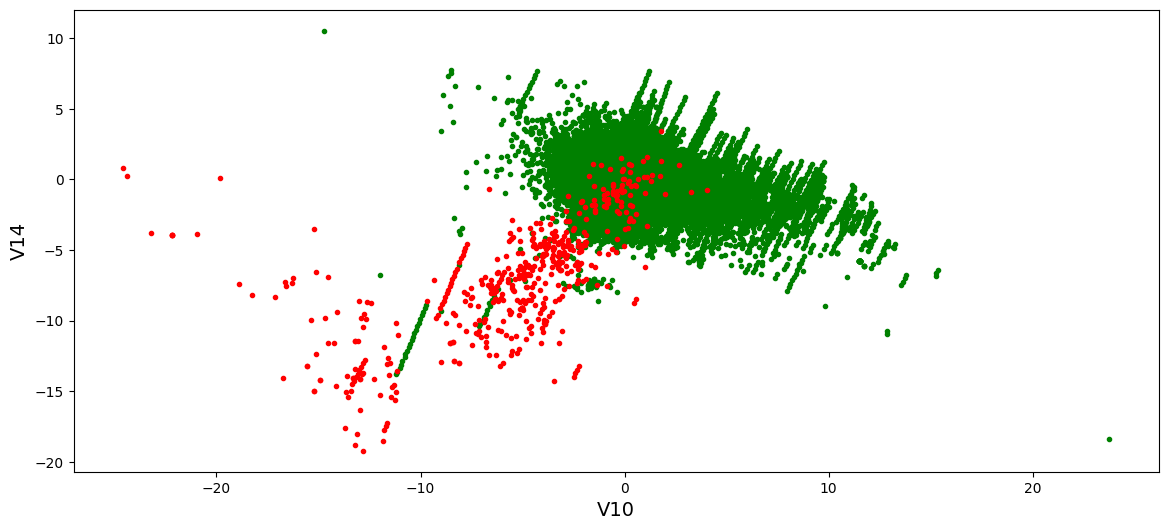

In [58]:
# Representación gráfica de dos características
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

In [60]:
def preprocess_data(df):
    """
    Preprocesses the credit card fraud data.

    Args:
        df (pd.DataFrame): The credit card fraud dataset.

    Returns:
        X_train (np.ndarray): Training features.
        X_valid (np.ndarray): Validation features.
        y_train (np.ndarray): Training labels.
        y_valid (np.ndarray): Validation labels.
    """
    # Handle missing values
    df = df.dropna()

    # Split features and labels
    X = df.drop('Class', axis=1).values
    y = df['Class'].values

    # Split into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    # Convert labels to categorical
    y_train = K.utils.to_categorical(y_train, 2)
    y_valid = K.utils.to_categorical(y_valid, 2)

    return X_train, X_valid, y_train, y_valid


In [61]:
# We display the types of each of the attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [62]:
# We check if any column has null values
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [63]:
X_train, X_valid, y_train, y_valid = preprocess_data(df)

In [64]:
def create_model(learning_rate, dropout_rate, num_units, l2_weight):
    """
    Creates a neural network model with the given hyperparameters.

    Args:
        learning_rate (float): Learning rate for the optimizer.
        dropout_rate (float): Dropout rate for regularization.
        num_units (int): Number of units in the hidden layer.
        l2_weight (float): L2 regularization weight.

    Returns:
        model (tf.keras.Model): Compiled neural network model.
    """
    model = K.Sequential()
    model.add(K.layers.Dense(num_units, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=K.regularizers.l2(l2_weight)))
    model.add(K.layers.Dropout(dropout_rate))
    model.add(K.layers.Dense(2, activation='softmax'))
    optimizer = K.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [65]:
def objective_function(params):
    """
    Objective function for Bayesian Optimization. Trains the model and returns the negative validation accuracy.

    Args:
        params (list): List of hyperparameters [learning_rate, dropout_rate, num_units, l2_weight, batch_size, epochs].

    Returns:
        float: Negative validation accuracy.
    """
    learning_rate, dropout_rate, num_units, l2_weight, batch_size, epochs = params[0]
    num_units = int(num_units)
    batch_size = int(batch_size)
    epochs = int(epochs)

    model = create_model(learning_rate, dropout_rate, num_units, l2_weight)
    checkpoint = K.callbacks.ModelCheckpoint(f'best_model_lr_{learning_rate}_units_{num_units}_dropout_{dropout_rate}_l2_{l2_weight}_batch_{batch_size}_epochs_{epochs}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, early_stop], verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return -val_acc

In [66]:
# Define the bounds of the hyperparameters
bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.01)},
    {'name': 'dropout_rate', 'type': 'continuous', 'domain': (0.1, 0.5)},
    {'name': 'num_units', 'type': 'discrete', 'domain': range(50, 501)},
    {'name': 'l2_weight', 'type': 'continuous', 'domain': (0.0001, 0.01)},
    {'name': 'batch_size', 'type': 'discrete', 'domain': range(32, 129)},
    {'name': 'epochs', 'type': 'discrete', 'domain': range(5, 51)}
]

In [ ]:
# Run Bayesian Optimization
optimizer = GPyOpt.methods.BayesianOptimization(f=objective_function, domain=bounds, initial_design_numdata=5, acquisition_type='EI', exact_feval=True)
optimizer.run_optimization(max_iter=30)


In [ ]:
# Get the optimal parameters
x_opt = optimizer.X[-1]
y_opt = optimizer.Y[-1]

In [ ]:
# Save optimization report
with open('bayes_opt.txt', 'w') as f:
    f.write("Optimization Results:\n")
    f.write(f"Best Parameters: {x_opt}\n")
    f.write(f"Best Objective: {-y_opt}\n")

In [ ]:
# Plot convergence
plt.plot(-optimizer.Y)
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('Convergence Plot')
plt.savefig('convergence_plot.png')
plt.show()